# ARC Prize 2025 - Exploratory Data Analysis

This notebook explores the ARC dataset and tests our solution pipeline.


In [2]:
import sys
from pathlib import Path

# Add parent directory and src to path
parent_dir = Path.cwd().parent
src_dir = parent_dir / "src"
sys.path.insert(0, str(parent_dir))
sys.path.insert(0, str(src_dir))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import our modules
from src.data.loader import ARCDataLoader
from src.core.pipeline import ARCReasoningPipeline, PipelineConfig

In [3]:
# Load the ARC dataset
loader = ARCDataLoader()

# Validate dataset files
validation_results = loader.validate_dataset_files()
print("Dataset validation:")
for file_type, is_valid in validation_results.items():
    status = "✅" if is_valid else "❌"
    print(f"{status} {file_type}")

Dataset validation:
✅ training_challenges
✅ training_solutions
✅ evaluation_challenges
✅ evaluation_solutions
✅ test_challenges
✅ sample_submission


In [4]:
# Get dataset statistics
stats = loader.get_dataset_stats()
print("Dataset Statistics:")
for dataset_name, dataset_stats in stats.items():
    print(f"\n{dataset_name.title()} Set:")
    print(f"  Tasks: {dataset_stats['count']}")
    print(f"  Avg training examples: {dataset_stats['avg_train_examples']:.1f}")
    print(f"  Avg test inputs: {dataset_stats['avg_test_inputs']:.1f}")

Dataset Statistics:

Training Set:
  Tasks: 1000
  Avg training examples: 3.2
  Avg test inputs: 1.1

Evaluation Set:
  Tasks: 120
  Avg training examples: 3.0
  Avg test inputs: 1.4

Test Set:
  Tasks: 240
  Avg training examples: 3.2
  Avg test inputs: 1.1


In [5]:
# Load a few training tasks to explore
training_tasks = loader.load_training_tasks()[:5]  # Load first 5 tasks
print(f"Loaded {len(training_tasks)} training tasks for exploration")

Loaded 5 training tasks for exploration


Task ID: 00576224
Training examples: 2
Test inputs: 1

Training Example 1:


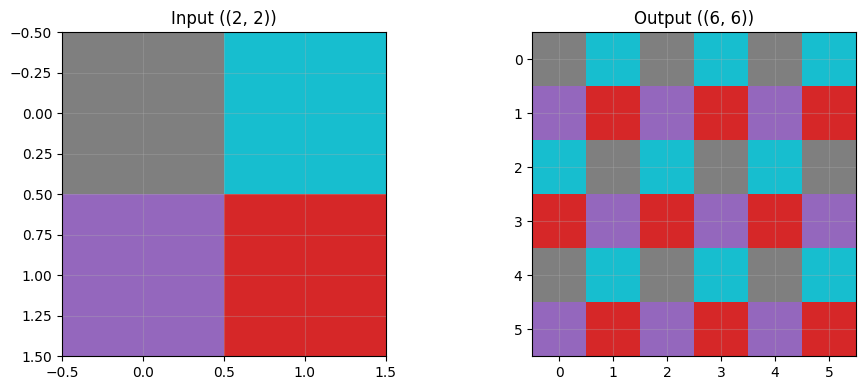


Training Example 2:


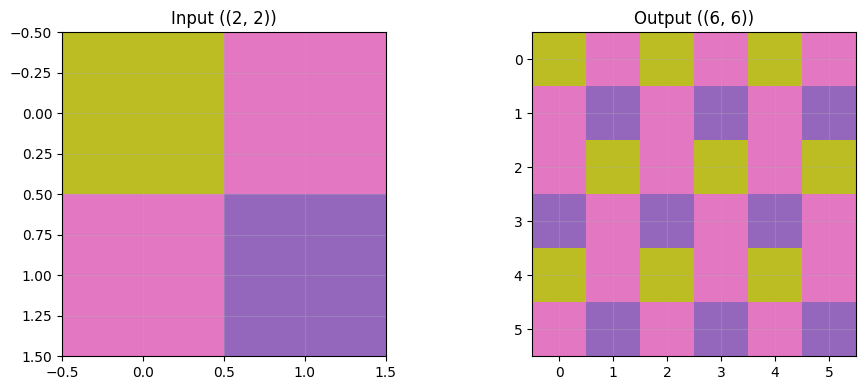

In [6]:
def visualize_task(task, max_examples=2):
    """Visualize a task with its training examples"""
    print(f"Task ID: {task.task_id}")
    print(f"Training examples: {len(task.train_pairs)}")
    print(f"Test inputs: {len(task.test_inputs)}")
    
    # Show first few training examples
    for i, pair in enumerate(task.train_pairs[:max_examples]):
        print(f"\nTraining Example {i+1}:")
        
        input_grid = np.array(pair['input'])
        output_grid = np.array(pair['output'])
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        # Input
        ax1.imshow(input_grid, cmap='tab10', vmin=0, vmax=9)
        ax1.set_title(f'Input ({input_grid.shape})')
        ax1.grid(True, alpha=0.3)
        
        # Output
        ax2.imshow(output_grid, cmap='tab10', vmin=0, vmax=9)
        ax2.set_title(f'Output ({output_grid.shape})')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Visualize first task
if training_tasks:
    visualize_task(training_tasks[0])

In [7]:
# Test our pipeline on a simple task
config = PipelineConfig(
    max_hypotheses_per_component=3,
    max_total_hypotheses=5,
    enable_llm=False,  # Disable for quick test
    enable_vision=False,
    enable_symbolic=True
)

pipeline = ARCReasoningPipeline(config)
print("Pipeline initialized successfully!")
print("Components:", pipeline.get_pipeline_stats()['components'])

Pipeline initialized successfully!
Components: {'preprocessor': True, 'symbolic_solver': True, 'llm_reasoner': False, 'vision_solver': False, 'executor': True, 'verifier': True}


In [8]:
# Test pipeline on first training task
if training_tasks:
    test_task = training_tasks[0]
    print(f"Testing pipeline on task: {test_task.task_id}")
    
    solution = pipeline.solve_task(test_task)
    
    print(f"\nSolution Results:")
    print(f"Execution time: {solution.execution_time:.2f}s")
    print(f"Hypotheses generated: {len(solution.hypotheses)}")
    print(f"Predictions generated: {len(solution.predictions)}")
    
    if solution.hypotheses:
        best_hypothesis = solution.hypotheses[0]
        print(f"\nBest hypothesis:")
        print(f"Confidence: {best_hypothesis.confidence:.3f}")
        print(f"Description: {best_hypothesis.description}")
        print(f"Generated by: {best_hypothesis.generated_by}")

2025-09-03 02:06:53,429 - arc_pipeline - INFO - Starting to solve task 00576224
2025-09-03 02:06:53,439 - arc_pipeline - INFO - Phase 1: Preprocessing grids...
2025-09-03 02:06:53,439 - arc_pipeline - INFO - Phase 1: Preprocessing grids...
2025-09-03 02:06:53,507 - arc_pipeline - INFO - Phase 2: Generating hypotheses...
2025-09-03 02:06:53,510 - arc_pipeline - INFO - Symbolic solver generated 3 hypotheses
2025-09-03 02:06:53,507 - arc_pipeline - INFO - Phase 2: Generating hypotheses...
2025-09-03 02:06:53,510 - arc_pipeline - INFO - Symbolic solver generated 3 hypotheses
2025-09-03 02:06:53,512 - arc_pipeline - INFO - Generated 3 hypotheses
2025-09-03 02:06:53,519 - arc_pipeline - INFO - Phase 3: Verifying and ranking hypotheses...
2025-09-03 02:06:53,521 - arc_pipeline - INFO - Selected 0 best hypotheses
2025-09-03 02:06:53,522 - arc_pipeline - INFO - Phase 5: Generating predictions...
2025-09-03 02:06:53,523 - arc_pipeline - INFO - Task solved in 0.09 seconds
2025-09-03 02:06:53,512 

Testing pipeline on task: 00576224

Solution Results:
Execution time: 0.09s
Hypotheses generated: 0
Predictions generated: 1


In [9]:
# Analyze grid sizes and colors across dataset
def analyze_dataset_properties(tasks):
    """Analyze properties of tasks in the dataset"""
    input_sizes = []
    output_sizes = []
    colors_used = set()
    
    for task in tasks:
        for pair in task.train_pairs:
            input_grid = np.array(pair['input'])
            output_grid = np.array(pair['output'])
            
            input_sizes.append(input_grid.shape)
            output_sizes.append(output_grid.shape)
            
            colors_used.update(input_grid.flatten())
            colors_used.update(output_grid.flatten())
    
    return {
        'input_sizes': input_sizes,
        'output_sizes': output_sizes,
        'colors_used': sorted(colors_used),
        'unique_input_sizes': len(set(input_sizes)),
        'unique_output_sizes': len(set(output_sizes))
    }

properties = analyze_dataset_properties(training_tasks)
print(f"Colors used: {properties['colors_used']}")
print(f"Unique input sizes: {properties['unique_input_sizes']}")
print(f"Unique output sizes: {properties['unique_output_sizes']}")

Colors used: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Unique input sizes: 10
Unique output sizes: 8
